# **Data Aquistion**


This notebook downloads the required data for state-of-the-art LCZ Classification:

1. Setup the project by defining the city of interest
2. City boundary polygon download from OpenStreetMap 
3. Sentinel-2 imagery download using AWS S3
4. ALOS DSM 30m download from Google Earth Engine
5. Impervious Surface Area download from Google Earth Engine 
6. Tree Canopy Height download from Google Earth Engine
7. Building Height download from NRCan

## **1. Project Setup**


This code block imports the necessery Python libraries

### 1.1. Import Libraries

In [1]:
%load_ext autoreload
%autoreload 

import sys
import os

# Add the module's parent directory to sys.path
module_path = os.path.abspath(os.path.join('..'))
if module_path not in sys.path:
    sys.path.append(module_path)

from lcz_classification.config import  *
from lcz_classification.dataset import get_matching_scenes, download_tiles, ee_download, fetch_metadata
from lcz_classification.util import tiles_from_bbox
import geopandas as gpd
import matplotlib.pyplot as plt
import ee
import numpy as np
import pandas as pd


- Parent directory for Toronto already exists, retrievine folder paths...
- Folder paths for Toronto retrieved.


#### 1.2. Setup Directories

<Axes: >

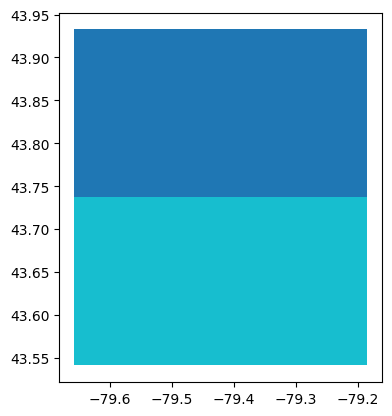

In [ ]:

study_area=fetch_metadata('STUDY_AREA')

bounds=list(study_area.total_bounds)

s2_tiles=fetch_metadata('S2_TILES')

tiles_gdf=tiles_from_bbox(bounds, tile_dims=TILE_DIMS).sort_values('tile_id')
tiles_gdf.plot('tile_id')
# tiles_gdf=tiles_gdf[tiles_gdf.tile_id == 'B3']

# 2.1. Get Study Area

In [3]:
study_area.explore(
                style=dict(
                    fill = False,
                    color='red'
                ),
)

### 1.3 Authenticate Google Earth Engine

In [4]:
if ee.Authenticate() == True:
    ee.Initialize(project=EE_PROJECT_NAME)    
else:
    ee.Authenticate(force = True)
    ee.Initialize(project=EE_PROJECT_NAME)    

# **3. Sentinel-2 Download**

Using download_tiles function, Sentinel-2 data is downloaded from the AWS S3 Bucket using boto3. The city boundary polygon and data range are used to derive matching scenes withiin the sentinel-2 database.

https://registry.opendata.aws/sentinel-2/


In [24]:



# Function to get least-cloudy image for one tile
# Function to get least-cloudy image for one tile
def get_least_cloudy(col,tile_id):
    filtered = (
        col
        .filter(ee.Filter.eq('MGRS_TILE', tile_id))
        .sort('CLOUDY_PIXEL_PERCENTAGE')  # least cloudy first
    )
    return ee.Image(filtered.first())
    

def normalize(image):
    bands = ['B2', 'B3', 'B4', 'B8']  # Blue, Green, Red, NIR
    stats = image.select(bands).reduceRegion(
        reducer=ee.Reducer.percentile([2, 98]),
        geometry=image.geometry(),
        scale=20,
        maxPixels=1e9
    )
    min_dict = ee.Dictionary({
        band: stats.get(f'{band}_p2') for band in bands
    })
    max_dict = ee.Dictionary({
        band: stats.get(f'{band}_p98') for band in bands
    })
    
    # Stretch each band
    stretched = image.select(bands).clamp(min_dict, max_dict).unitScale(min_dict, max_dict)
    return image.addBands(stretched, overwrite=True)


In [21]:
def mask_s2_clouds(image):
  """Masks clouds in a Sentinel-2 image using the QA band.

  Args:
      image (ee.Image): A Sentinel-2 image.

  Returns:
      ee.Image: A cloud-masked Sentinel-2 image.
  """
  qa = image.select('QA60')

  # Bits 10 and 11 are clouds and cirrus, respectively.
  cloud_bit_mask = 1 << 10
  cirrus_bit_mask = 1 << 11

  # Both flags should be set to zero, indicating clear conditions.
  mask = (
      qa.bitwiseAnd(cloud_bit_mask)
      .eq(0)
      .And(qa.bitwiseAnd(cirrus_bit_mask).eq(0))
  )

  return image.updateMask(mask).divide(10000)

# 1. Define a function to calculate footprint area and add it as a property
def add_area(image):
    area = image.geometry().area().divide(1e6)  # Area in km²
    return image.set('footprint_area', area)

def invertCloudProbabilityBand(img):
  cldProb = img.select('AOT')
  cldProbInv = cldProb.multiply(-1).rename('quality')
  return img.addBands(cldProbInv)



def ee_least_cloudy(col, bbox_geom):
        least_cloudy_images=list()
        ee_tile_ids=sorted(col.aggregate_array('MGRS_TILE').distinct().getInfo())
        least_cloudy_images=list()
        aerosol_filter=ee.Filter.lt('MEAN_AOT', 0.5)
        for ee_tile in ee_tile_ids:
            
            tile_filter=ee.Filter.eq('MGRS_TILE',ee_tile)
            cloud_filter=ee.Filter.lt('CLOUDY_PIXEL_PERCENTAGE',5)

            clearest_image=(col
                            .filter(tile_filter)
                            .filter(cloud_filter)
                            .map(add_area)
                            .sort('footprint_area', False)
                            .first()
                            ) 
            
            least_cloudy_val=clearest_image.get('CLOUDY_PIXEL_PERCENTAGE').getInfo()
            image_id = clearest_image.getInfo()['properties']['system:index']
            print(f"- Lowest Cloud Percentage in Image {image_id.split('/')[-1]} : {round(least_cloudy_val * 100, 1)}%")

            least_cloudy_images.append(clearest_image)


        return ee.ImageCollection(ee.List(least_cloudy_images))

In [25]:
import geemap


START_DATE , END_DATE= ('2023-05-01' ,'2023-05-30')



        # return clearest_image

images=list()
# iterate throught tile geometries generated with tiles_from_bbox()
for idx, tile in tiles_gdf.iterrows():

     tile_id = tile.tile_id
     print(f"Retrieving ImageCollection for Tile {tile_id}")
     print(f"===================================================")
     ee_geom= ee.Geometry.Rectangle(tile.geometry.bounds)
     

     # Get ImageCollection filtered by date range, cloud percentage and first tile
     col=(ee.ImageCollection('COPERNICUS/S2_SR_HARMONIZED')
          .filterBounds(ee_geom)
          .filterDate(START_DATE, END_DATE)
          .filter(ee.Filter.lt('CLOUDY_PIXEL_PERCENTAGE',5))
          # .map(mask_s2_clouds)
          )
     
     features = col.getInfo()['features']
     print(f"- Number of Features: {len(features)}")
     # Retrieve Least Cloudy Images from the Collection
     # least_cloudy_col = ee_least_cloudy(col, ee_geom)
     # print(f"- Number of Features after Filtering: {len(least_cloudy_col.getInfo()['features'])}")
     # Mosaic Images of Least Cloudy Collection and Clip to Bounds 
     image=col.mean()
     
     images.append(image)
     # image = mask_s2_clouds(image)
     
     # Get Matching Tile IDs
     # break
     print(f'Downloading Images for Tile: {tile_id}')
     # Iterate through target S2 bands and export
     for band in S2_TARGET_BANDS:
          out_dir = f"{S2_RAW}/T{tile_id}"
          filename=f"{out_dir}/{band}.tif"
          if os.path.exists(out_dir) == False:
               os.mkdir(out_dir)
               
          if os.path.exists(filename) == False:
               print(f"- Downloading ee.Image for tile {tile_id} and Band {band}")
               ee_band=band.replace('0','')
               # Export Image using geemap
               geemap.ee_export_image(
                         image.select(ee_band),
                         filename=filename,
                         scale=CELL_RESOLUTION,
                         file_per_band=False,
                         crs='EPSG:4326', 
                         region = ee_geom
                    )
          else:
               print(f"- GeoTIFF for Tile {tile_id} Band {band} already downloaded")

     print(f"===================================================")
     


Retrieving ImageCollection for Tile A1
- Number of Features: 3
- GeoTIFF for Tile A1 Band B02 already downloaded
- GeoTIFF for Tile A1 Band B03 already downloaded
- Downloading ee.Image for tile A1 and Band B04
Generating URL ...
Please wait ...
Data downloaded to d:\GeoAI\projects\LCZ_Classification\data\toronto\raw\sentinel2\TA1\B04.tif
- Downloading ee.Image for tile A1 and Band B05
Generating URL ...
Please wait ...
Data downloaded to d:\GeoAI\projects\LCZ_Classification\data\toronto\raw\sentinel2\TA1\B05.tif
- Downloading ee.Image for tile A1 and Band B06
Generating URL ...
Please wait ...
Data downloaded to d:\GeoAI\projects\LCZ_Classification\data\toronto\raw\sentinel2\TA1\B06.tif
- Downloading ee.Image for tile A1 and Band B07
Generating URL ...
Please wait ...
Data downloaded to d:\GeoAI\projects\LCZ_Classification\data\toronto\raw\sentinel2\TA1\B07.tif
- GeoTIFF for Tile A1 Band B8A already downloaded
- GeoTIFF for Tile A1 Band B11 already downloaded
- GeoTIFF for Tile A1 Ban

In [23]:

# Select bands for visualization (e.g., RGB)
# vis_params = {
#     'min': 0,
#     'max': 3000,
#     'bands': ['B4', 'B3', 'B2'],  # RGB
# }

vis_params = {
    'min': 0,
    'max': 3000,
    'bands': ['B4', 'B3', 'B2'],  # RGB
}


# Create an interactive map

img=images[0]
x,y = ee.Geometry.Rectangle(bounds).centroid().getInfo()['coordinates']
Map = geemap.Map(center=(y,x), zoom=10)

# img=ee.Image(least_cloudy_col.toList(least_cloudy_col.size()).get(1))
# Map.addLayer(first_image, vis_params, 'Sentinel-2 RGB 1')
Map.addLayer(img, vis_params, 'Sentinel-2 RGB 2')
# Map.addLayer(images[2], vis_params, 'Sentinel-2 RGB 3')
# Map.addLayer(images[3], vis_params, 'Sentinel-2 RGB 4')
Map.addLayer(ee.Geometry.Rectangle(bounds), {'fill': None}, 'AOI')
Map

Map(center=[43.73675614307173, -79.42185089957516], controls=(WidgetControl(options=['position', 'transparent_…

## **4. DSM from ALOS 30m**

In [ ]:
# Download ALOS DSM Data from Google Earth Engine

ee_download(
            asset_id="JAXA/ALOS/AW3D30/V3_2",
            bands=["DSM"],
            bbox = bounds, 
            output_dir=DSM_RAW,
            scale=CELL_RESOLUTION,
            tile_dims=(2,1)
            )



The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload
IMAGE_COLLECTION
Generating URL ...
Please wait ...
Data downloaded to d:\GeoAI\projects\LCZ_Classification\data\toronto\raw\alos_dsm_30m\N043W079_DSM_A1.tif
Generating URL ...
Please wait ...
Data downloaded to d:\GeoAI\projects\LCZ_Classification\data\toronto\raw\alos_dsm_30m\N043W079_DSM_B1.tif
Generating URL ...
Please wait ...
Data downloaded to d:\GeoAI\projects\LCZ_Classification\data\toronto\raw\alos_dsm_30m\N043W080_DSM_A1.tif
Generating URL ...
Please wait ...
Data downloaded to d:\GeoAI\projects\LCZ_Classification\data\toronto\raw\alos_dsm_30m\N043W080_DSM_B1.tif
Generating URL ...
Please wait ...
Data downloaded to d:\GeoAI\projects\LCZ_Classification\data\toronto\raw\alos_dsm_30m\N043W081_DSM_A1.tif
Generating URL ...
Please wait ...
Data downloaded to d:\GeoAI\projects\LCZ_Classification\data\toronto\raw\alos_dsm_30m\N043W081_DSM_B1.tif
Generating URL ...
Please wait ...
Data downloade

## **5. Impervious Surface Area**

In [21]:
# # Download Impervious Surface Area from Google Earth Engine

# ee_download(
#             asset_id="projects/sat-io/open-datasets/GISD30_1985_2020",
#             bands=["b1"],
#             bbox =bounds, 
#             output_dir=IS_RAW,
#             scale=CELL_RESOLUTION,
#             tile_dims=tile_dims
#             )

IMAGE
Generating URL ...
An error occurred while downloading.
Total request size (74553936 bytes) must be less than or equal to 50331648 bytes.


## **6. Tree Canopy Height**

In [26]:
# Download Canopy Height from Google Earth Engine


ee_download(
            asset_id="users/nlang/ETH_GlobalCanopyHeight_2020_10m_v1",
            bands=["b1"],
            bbox = bounds, 
            output_dir=CH_RAW,
            scale=10,
            tile_dims=(4,4)
            )

IMAGE
Generating URL ...
Please wait ...
Data downloaded to d:\GeoAI\projects\LCZ_Classification\data\toronto\raw\canopy_height\ETH_GlobalCanopyHeight_2020_10m_v1_b1_A4.tif
Generating URL ...
Please wait ...
Data downloaded to d:\GeoAI\projects\LCZ_Classification\data\toronto\raw\canopy_height\ETH_GlobalCanopyHeight_2020_10m_v1_b1_A3.tif
Generating URL ...
Please wait ...
Data downloaded to d:\GeoAI\projects\LCZ_Classification\data\toronto\raw\canopy_height\ETH_GlobalCanopyHeight_2020_10m_v1_b1_A2.tif
Generating URL ...
Please wait ...
Data downloaded to d:\GeoAI\projects\LCZ_Classification\data\toronto\raw\canopy_height\ETH_GlobalCanopyHeight_2020_10m_v1_b1_A1.tif
Generating URL ...
Please wait ...
Data downloaded to d:\GeoAI\projects\LCZ_Classification\data\toronto\raw\canopy_height\ETH_GlobalCanopyHeight_2020_10m_v1_b1_B4.tif
Generating URL ...
Please wait ...
Data downloaded to d:\GeoAI\projects\LCZ_Classification\data\toronto\raw\canopy_height\ETH_GlobalCanopyHeight_2020_10m_v1_b1

## **7. Building Height Data**

Download building height data for British Columbia from the NRCan Website- https://ftp.maps.canada.ca/pub/nrcan_rncan/extraction/auto_building/fgdb/

In [28]:
import requests
from bs4 import BeautifulSoup
import os
from tqdm import tqdm

# Base URL of the directory
BASE_URL = "https://ftp.maps.canada.ca/pub/nrcan_rncan/extraction/auto_building/fgdb/"
PROVINCE = "ON"
# Create a session
session = requests.Session()

def get_links(url, province):
    print(f"Fetching links from {url}")
    response = session.get(url)
    response.raise_for_status()

    soup = BeautifulSoup(response.text, 'html.parser')
    links = []
    for link in soup.find_all('a'):
        href = link.get('href')
        if href and province in href and href.endswith('.zip'):
            full_url = url + href
            links.append(full_url)
    return links

def download_file(url, dest_folder="."):
    local_filename = os.path.join(dest_folder, url.split("/")[-1])
    print(f"Downloading: {url}")
    with session.get(url, stream=True) as r:
        r.raise_for_status()
        total = int(r.headers.get('content-length', 0))
        with open(local_filename, 'wb') as f, tqdm(
            desc=local_filename,
            total=total,
            unit='B',
            unit_scale=True,
            unit_divisor=1024,
        ) as bar:
            for chunk in r.iter_content(chunk_size=8192):
                if chunk:
                    f.write(chunk)
                    bar.update(len(chunk))
    print(f"Saved to {local_filename}")

if __name__ == "__main__":
    links = get_links(BASE_URL, PROVINCE)
    print(f"Found {len(links)} {PROVINCE}-related files.")
    for link in links:
        download_file(link, dest_folder=BH_RAW)


Fetching links from https://ftp.maps.canada.ca/pub/nrcan_rncan/extraction/auto_building/fgdb/
Found 29 ON-related files.
Downloading: https://ftp.maps.canada.ca/pub/nrcan_rncan/extraction/auto_building/fgdb/Autobuilding_ON_2016-17-Peterborough_fgdb.zip


../data/toronto/raw/building_height\Autobuilding_ON_2016-17-Peterborough_fgdb.zip: 100%|██████████| 33.9M/33.9M [00:17<00:00, 2.01MB/s]


Saved to ../data/toronto/raw/building_height\Autobuilding_ON_2016-17-Peterborough_fgdb.zip
Downloading: https://ftp.maps.canada.ca/pub/nrcan_rncan/extraction/auto_building/fgdb/Autobuilding_ON_2017-LakeErie_fgdb.zip


../data/toronto/raw/building_height\Autobuilding_ON_2017-LakeErie_fgdb.zip: 100%|██████████| 94.5M/94.5M [00:21<00:00, 4.70MB/s]


Saved to ../data/toronto/raw/building_height\Autobuilding_ON_2017-LakeErie_fgdb.zip
Downloading: https://ftp.maps.canada.ca/pub/nrcan_rncan/extraction/auto_building/fgdb/Autobuilding_ON_BRAMPTON_fgdb.zip


../data/toronto/raw/building_height\Autobuilding_ON_BRAMPTON_fgdb.zip: 100%|██████████| 6.39M/6.39M [00:07<00:00, 944kB/s] 


Saved to ../data/toronto/raw/building_height\Autobuilding_ON_BRAMPTON_fgdb.zip
Downloading: https://ftp.maps.canada.ca/pub/nrcan_rncan/extraction/auto_building/fgdb/Autobuilding_ON_Eastern_Ontario_2022_fgdb.zip


../data/toronto/raw/building_height\Autobuilding_ON_Eastern_Ontario_2022_fgdb.zip: 100%|██████████| 35.5M/35.5M [00:20<00:00, 1.82MB/s]


Saved to ../data/toronto/raw/building_height\Autobuilding_ON_Eastern_Ontario_2022_fgdb.zip
Downloading: https://ftp.maps.canada.ca/pub/nrcan_rncan/extraction/auto_building/fgdb/Autobuilding_ON_Eastern_Ontario_Part1_2021_fgdb.zip


../data/toronto/raw/building_height\Autobuilding_ON_Eastern_Ontario_Part1_2021_fgdb.zip: 100%|██████████| 13.2M/13.2M [00:03<00:00, 4.45MB/s]


Saved to ../data/toronto/raw/building_height\Autobuilding_ON_Eastern_Ontario_Part1_2021_fgdb.zip
Downloading: https://ftp.maps.canada.ca/pub/nrcan_rncan/extraction/auto_building/fgdb/Autobuilding_ON_Eastern_Ontario_Part2_2021_fgdb.zip


../data/toronto/raw/building_height\Autobuilding_ON_Eastern_Ontario_Part2_2021_fgdb.zip: 100%|██████████| 12.3M/12.3M [00:02<00:00, 4.98MB/s]


Saved to ../data/toronto/raw/building_height\Autobuilding_ON_Eastern_Ontario_Part2_2021_fgdb.zip
Downloading: https://ftp.maps.canada.ca/pub/nrcan_rncan/extraction/auto_building/fgdb/Autobuilding_ON_FHIMP_PICAI_Quinte_Belleville_UTM18_2022_fgdb.zip


../data/toronto/raw/building_height\Autobuilding_ON_FHIMP_PICAI_Quinte_Belleville_UTM18_2022_fgdb.zip: 100%|██████████| 25.8M/25.8M [00:06<00:00, 4.39MB/s]


Saved to ../data/toronto/raw/building_height\Autobuilding_ON_FHIMP_PICAI_Quinte_Belleville_UTM18_2022_fgdb.zip
Downloading: https://ftp.maps.canada.ca/pub/nrcan_rncan/extraction/auto_building/fgdb/Autobuilding_ON_GTA_2023_fgdb.zip


../data/toronto/raw/building_height\Autobuilding_ON_GTA_2023_fgdb.zip: 100%|██████████| 190M/190M [00:45<00:00, 4.36MB/s] 


Saved to ../data/toronto/raw/building_height\Autobuilding_ON_GTA_2023_fgdb.zip
Downloading: https://ftp.maps.canada.ca/pub/nrcan_rncan/extraction/auto_building/fgdb/Autobuilding_ON_Georgian_Bay_2022_fgdb.zip


../data/toronto/raw/building_height\Autobuilding_ON_Georgian_Bay_2022_fgdb.zip: 100%|██████████| 27.6M/27.6M [00:05<00:00, 5.69MB/s]


Saved to ../data/toronto/raw/building_height\Autobuilding_ON_Georgian_Bay_2022_fgdb.zip
Downloading: https://ftp.maps.canada.ca/pub/nrcan_rncan/extraction/auto_building/fgdb/Autobuilding_ON_HALTON_fgdb.zip


../data/toronto/raw/building_height\Autobuilding_ON_HALTON_fgdb.zip: 100%|██████████| 25.4M/25.4M [00:04<00:00, 5.65MB/s]


Saved to ../data/toronto/raw/building_height\Autobuilding_ON_HALTON_fgdb.zip
Downloading: https://ftp.maps.canada.ca/pub/nrcan_rncan/extraction/auto_building/fgdb/Autobuilding_ON_Hamilton_Niagara_2021_2_fgdb.zip


../data/toronto/raw/building_height\Autobuilding_ON_Hamilton_Niagara_2021_2_fgdb.zip: 100%|██████████| 51.6M/51.6M [00:06<00:00, 8.27MB/s]


Saved to ../data/toronto/raw/building_height\Autobuilding_ON_Hamilton_Niagara_2021_2_fgdb.zip
Downloading: https://ftp.maps.canada.ca/pub/nrcan_rncan/extraction/auto_building/fgdb/Autobuilding_ON_Huron_GeorgianBay_spring_2023_fgdb.zip


../data/toronto/raw/building_height\Autobuilding_ON_Huron_GeorgianBay_spring_2023_fgdb.zip: 100%|██████████| 10.2M/10.2M [00:01<00:00, 6.47MB/s]


Saved to ../data/toronto/raw/building_height\Autobuilding_ON_Huron_GeorgianBay_spring_2023_fgdb.zip
Downloading: https://ftp.maps.canada.ca/pub/nrcan_rncan/extraction/auto_building/fgdb/Autobuilding_ON_KawarthaLakes_spring_2023_fgdb.zip


../data/toronto/raw/building_height\Autobuilding_ON_KawarthaLakes_spring_2023_fgdb.zip: 100%|██████████| 13.9M/13.9M [00:04<00:00, 2.99MB/s]


Saved to ../data/toronto/raw/building_height\Autobuilding_ON_KawarthaLakes_spring_2023_fgdb.zip
Downloading: https://ftp.maps.canada.ca/pub/nrcan_rncan/extraction/auto_building/fgdb/Autobuilding_ON_Lake_Erie_2018_fgdb.zip


../data/toronto/raw/building_height\Autobuilding_ON_Lake_Erie_2018_fgdb.zip: 100%|██████████| 36.6M/36.6M [00:06<00:00, 5.97MB/s]


Saved to ../data/toronto/raw/building_height\Autobuilding_ON_Lake_Erie_2018_fgdb.zip
Downloading: https://ftp.maps.canada.ca/pub/nrcan_rncan/extraction/auto_building/fgdb/Autobuilding_ON_Lake_Erie_Fall_2017_fgdb.zip


../data/toronto/raw/building_height\Autobuilding_ON_Lake_Erie_Fall_2017_fgdb.zip: 100%|██████████| 42.2M/42.2M [00:07<00:00, 5.76MB/s]


Saved to ../data/toronto/raw/building_height\Autobuilding_ON_Lake_Erie_Fall_2017_fgdb.zip
Downloading: https://ftp.maps.canada.ca/pub/nrcan_rncan/extraction/auto_building/fgdb/Autobuilding_ON_Lake_Huron_2022_fgdb.zip


../data/toronto/raw/building_height\Autobuilding_ON_Lake_Huron_2022_fgdb.zip: 100%|██████████| 35.7M/35.7M [00:07<00:00, 5.07MB/s]


Saved to ../data/toronto/raw/building_height\Autobuilding_ON_Lake_Huron_2022_fgdb.zip
Downloading: https://ftp.maps.canada.ca/pub/nrcan_rncan/extraction/auto_building/fgdb/Autobuilding_ON_Lake_Nipissing_2020_2_fgdb.zip


../data/toronto/raw/building_height\Autobuilding_ON_Lake_Nipissing_2020_2_fgdb.zip: 100%|██████████| 8.58M/8.58M [00:01<00:00, 5.11MB/s]


Saved to ../data/toronto/raw/building_height\Autobuilding_ON_Lake_Nipissing_2020_2_fgdb.zip
Downloading: https://ftp.maps.canada.ca/pub/nrcan_rncan/extraction/auto_building/fgdb/Autobuilding_ON_Lake_Simcoe_2019_fgdb.zip


../data/toronto/raw/building_height\Autobuilding_ON_Lake_Simcoe_2019_fgdb.zip: 100%|██████████| 15.3M/15.3M [00:03<00:00, 4.95MB/s]


Saved to ../data/toronto/raw/building_height\Autobuilding_ON_Lake_Simcoe_2019_fgdb.zip
Downloading: https://ftp.maps.canada.ca/pub/nrcan_rncan/extraction/auto_building/fgdb/Autobuilding_ON_Lake_Simcoe_OMAFRA_2022_fgdb.zip


../data/toronto/raw/building_height\Autobuilding_ON_Lake_Simcoe_OMAFRA_2022_fgdb.zip: 100%|██████████| 20.9M/20.9M [00:03<00:00, 5.91MB/s]


Saved to ../data/toronto/raw/building_height\Autobuilding_ON_Lake_Simcoe_OMAFRA_2022_fgdb.zip
Downloading: https://ftp.maps.canada.ca/pub/nrcan_rncan/extraction/auto_building/fgdb/Autobuilding_ON_ON_Sudbury_UTM17_2023_fgdb.zip


../data/toronto/raw/building_height\Autobuilding_ON_ON_Sudbury_UTM17_2023_fgdb.zip: 100%|██████████| 17.0M/17.0M [00:02<00:00, 7.27MB/s]


Saved to ../data/toronto/raw/building_height\Autobuilding_ON_ON_Sudbury_UTM17_2023_fgdb.zip
Downloading: https://ftp.maps.canada.ca/pub/nrcan_rncan/extraction/auto_building/fgdb/Autobuilding_ON_Ottawa_Gatineau_2020_fgdb.zip


../data/toronto/raw/building_height\Autobuilding_ON_Ottawa_Gatineau_2020_fgdb.zip: 100%|██████████| 55.4M/55.4M [00:10<00:00, 5.48MB/s]


Saved to ../data/toronto/raw/building_height\Autobuilding_ON_Ottawa_Gatineau_2020_fgdb.zip
Downloading: https://ftp.maps.canada.ca/pub/nrcan_rncan/extraction/auto_building/fgdb/Autobuilding_ON_PEEL_fgdb.zip


../data/toronto/raw/building_height\Autobuilding_ON_PEEL_fgdb.zip: 100%|██████████| 5.76M/5.76M [00:00<00:00, 6.48MB/s]


Saved to ../data/toronto/raw/building_height\Autobuilding_ON_PEEL_fgdb.zip
Downloading: https://ftp.maps.canada.ca/pub/nrcan_rncan/extraction/auto_building/fgdb/Autobuilding_ON_QC_Riviere_Outaouais_2020_fgdb.zip


../data/toronto/raw/building_height\Autobuilding_ON_QC_Riviere_Outaouais_2020_fgdb.zip: 100%|██████████| 6.99M/6.99M [00:01<00:00, 6.39MB/s]


Saved to ../data/toronto/raw/building_height\Autobuilding_ON_QC_Riviere_Outaouais_2020_fgdb.zip
Downloading: https://ftp.maps.canada.ca/pub/nrcan_rncan/extraction/auto_building/fgdb/Autobuilding_ON_SPL_ON_Hearst_UTM17_2019_fgdb.zip


../data/toronto/raw/building_height\Autobuilding_ON_SPL_ON_Hearst_UTM17_2019_fgdb.zip: 100%|██████████| 915k/915k [00:00<00:00, 4.55MB/s]


Saved to ../data/toronto/raw/building_height\Autobuilding_ON_SPL_ON_Hearst_UTM17_2019_fgdb.zip
Downloading: https://ftp.maps.canada.ca/pub/nrcan_rncan/extraction/auto_building/fgdb/Autobuilding_ON_Sarnia_Lake_Huron_OMAFRA_2022_fgdb.zip


../data/toronto/raw/building_height\Autobuilding_ON_Sarnia_Lake_Huron_OMAFRA_2022_fgdb.zip: 100%|██████████| 20.0M/20.0M [00:04<00:00, 5.06MB/s]


Saved to ../data/toronto/raw/building_height\Autobuilding_ON_Sarnia_Lake_Huron_OMAFRA_2022_fgdb.zip
Downloading: https://ftp.maps.canada.ca/pub/nrcan_rncan/extraction/auto_building/fgdb/Autobuilding_ON_South_Central_Durham_fgdb.zip


../data/toronto/raw/building_height\Autobuilding_ON_South_Central_Durham_fgdb.zip: 100%|██████████| 15.9M/15.9M [00:02<00:00, 5.75MB/s]


Saved to ../data/toronto/raw/building_height\Autobuilding_ON_South_Central_Durham_fgdb.zip
Downloading: https://ftp.maps.canada.ca/pub/nrcan_rncan/extraction/auto_building/fgdb/Autobuilding_QC_2009_701-09-PONTIAC_MTM09_fgdb.zip


../data/toronto/raw/building_height\Autobuilding_QC_2009_701-09-PONTIAC_MTM09_fgdb.zip: 100%|██████████| 190k/190k [00:00<00:00, 20.0MB/s]


Saved to ../data/toronto/raw/building_height\Autobuilding_QC_2009_701-09-PONTIAC_MTM09_fgdb.zip
Downloading: https://ftp.maps.canada.ca/pub/nrcan_rncan/extraction/auto_building/fgdb/Autobuilding_QC_2014_600014-35-PONTIAC_MTM09_fgdb.zip


../data/toronto/raw/building_height\Autobuilding_QC_2014_600014-35-PONTIAC_MTM09_fgdb.zip: 100%|██████████| 1.86M/1.86M [00:00<00:00, 3.28MB/s]


Saved to ../data/toronto/raw/building_height\Autobuilding_QC_2014_600014-35-PONTIAC_MTM09_fgdb.zip
Downloading: https://ftp.maps.canada.ca/pub/nrcan_rncan/extraction/auto_building/fgdb/Autobuilding_QC_VILLE_MONTREAL_fgdb.zip


../data/toronto/raw/building_height\Autobuilding_QC_VILLE_MONTREAL_fgdb.zip: 100%|██████████| 29.7M/29.7M [00:05<00:00, 6.10MB/s]

Saved to ../data/toronto/raw/building_height\Autobuilding_QC_VILLE_MONTREAL_fgdb.zip
